In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import rasterio
import sys

/tmp/ipykernel_431362/590086645.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# https://pygis.io/docs/d_access_census.html

In [3]:
# Set API key
c = Census('c2b7b1b0ee04a89666fd161e16d3e1dcec53d1b9')

In [4]:
va_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.MT.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2017)

In [5]:
# Create a dataframe from the census data
va_df = pd.DataFrame(va_census)

# Show the dataframe
va_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract
0,"Census Tract 9540, McCone County, Montana",1647.0,33.0,94.0,1728.0,30,055,954000
1,"Census Tract 1, Wheatland County, Montana",2076.0,197.0,214.0,2108.0,30,107,000100


In [6]:
print('Shape: ', va_df.shape)

Shape:  (271, 8)


In [7]:
# Access shapefile of Virginia census tracts
va_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_30_tract.zip")


In [8]:
# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
va_tract = va_tract.to_crs(epsg = 32617)

# Print GeoDataFrame of shapefile
print(va_tract.head(2))
print('Shape: ', va_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(va_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ   NAME  \
0      30      029  000101  30029000101  1400000US30029000101   1.01   
1      30      029  001101  30029001101  1400000US30029001101  11.01   

             NAMELSAD  MTFCC FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0   Census Tract 1.01  G5020        S  4688689678  89374843  +48.6403613   
1  Census Tract 11.01  G5020        S     1832500      6562  +48.1920787   

       INTPTLON                                           geometry  
0  -114.1929769  POLYGON ((-1971794.386 5963141.435, -1971710.0...  
1  -114.3261339  POLYGON ((-1954182.088 5900461.204, -1954169.5...  
Shape:  (319, 14)

The shapefile projection is: EPSG:32617


In [9]:
# Combine state, county, and tract columns together to create a new string and assign to new column
va_df["GEOID"] = va_df["state"] + va_df["county"] + va_df["tract"]

In [10]:
# Print head of dataframe
va_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 9540, McCone County, Montana",1647.0,33.0,94.0,1728.0,30,055,954000,30055954000
1,"Census Tract 1, Wheatland County, Montana",2076.0,197.0,214.0,2108.0,30,107,000100,30107000100


In [11]:
# Remove columns
va_df = va_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
va_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 9540, McCone County, Montana",1647.0,33.0,94.0,1728.0,30055954000
1,"Census Tract 1, Wheatland County, Montana",2076.0,197.0,214.0,2108.0,30107000100


In [12]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(va_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(va_tract.dtypes))

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


In [13]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
va_merge = va_tract.merge(va_df, on = "GEOID")

# Show result
print(va_merge.head(2))
print('Shape: ', va_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ NAME_x  \
0      30      029  000202  30029000202  1400000US30029000202   2.02   
1      30      083  070400  30083070400  1400000US30083070400    704   

            NAMELSAD  MTFCC FUNCSTAT      ALAND   AWATER     INTPTLAT  \
0  Census Tract 2.02  G5020        S   63713448  1647483  +48.3478868   
1   Census Tract 704  G5020        S  110952160  7286263  +47.7110807   

       INTPTLON                                           geometry  \
0  -114.1467985  POLYGON ((-1938224.368 5911777.933, -1938179.8...   
1  -104.1118055  POLYGON ((-1237690.414 5543464.506, -1237628.1...   

                                        NAME_y  C17002_001E  C17002_002E  \
0  Census Tract 2.02, Flathead County, Montana       2588.0         11.0   
1   Census Tract 704, Richland County, Montana       2872.0         52.0   

   C17002_003E  B01003_001E  
0        183.0       2588.0  
1         31.0       2872.0  
Shape:  (223, 19)


In [14]:
# Create new dataframe from select columns
va_poverty_tract = va_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
print(va_poverty_tract.head(2))
print('Shape: ', va_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      30      029  000202  30029000202   
1      30      083  070400  30083070400   

                                            geometry  C17002_001E  \
0  POLYGON ((-1938224.368 5911777.933, -1938179.8...       2588.0   
1  POLYGON ((-1237690.414 5543464.506, -1237628.1...       2872.0   

   C17002_002E  C17002_003E  B01003_001E  
0         11.0        183.0       2588.0  
1         52.0         31.0       2872.0  
Shape:  (223, 9)


In [15]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
va_poverty_county = va_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(va_poverty_county.head(2))
print('Shape: ', va_poverty_county.shape)

                                                   geometry     STATEFP  \
COUNTYFP                                                                  
001       POLYGON ((-2053420.067 5615930.461, -2053388.5...      303030   
003       POLYGON ((-1512290.638 5395589.281, -1511628.1...  3030303030   

                                 TRACTCE  \
COUNTYFP                                   
001                   000300000100000200   
003       940500000100940700940600940400   

                                                      GEOID  C17002_001E  \
COUNTYFP                                                                   
001                       300010003003000100010030001000200       8911.0   
003       3000394050030003000100300039407003000394060030...      13085.0   

          C17002_002E  C17002_003E  B01003_001E  
COUNTYFP                                         
001             559.0        874.0       9360.0  
003            1560.0       1944.0      13290.0  
Shape:  (55, 8)


In [16]:
# Get poverty rate and store values in new column
va_poverty_county["Poverty_Rate"] = (va_poverty_county["C17002_002E"] + va_poverty_county["C17002_003E"]) / va_poverty_county["B01003_001E"] * 100

# Show dataframe
va_poverty_county.head(2)

,geometry,STATEFP,TRACTCE,GEOID,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,,,,
001,"POLYGON ((-2053420.067 5615930.461, -2053388.5...",303030,000300000100000200,300010003003000100010030001000200,8911.0,559.0,874.0,9360.0,15.309829
003,"POLYGON ((-1512290.638 5395589.281, -1511628.1...",3030303030,940500000100940700940600940400,3000394050030003000100300039407003000394060030...,13085.0,1560.0,1944.0,13290.0,26.365688


Text(0.5, 1.0, 'Poverty Rates (%) in Virginia')

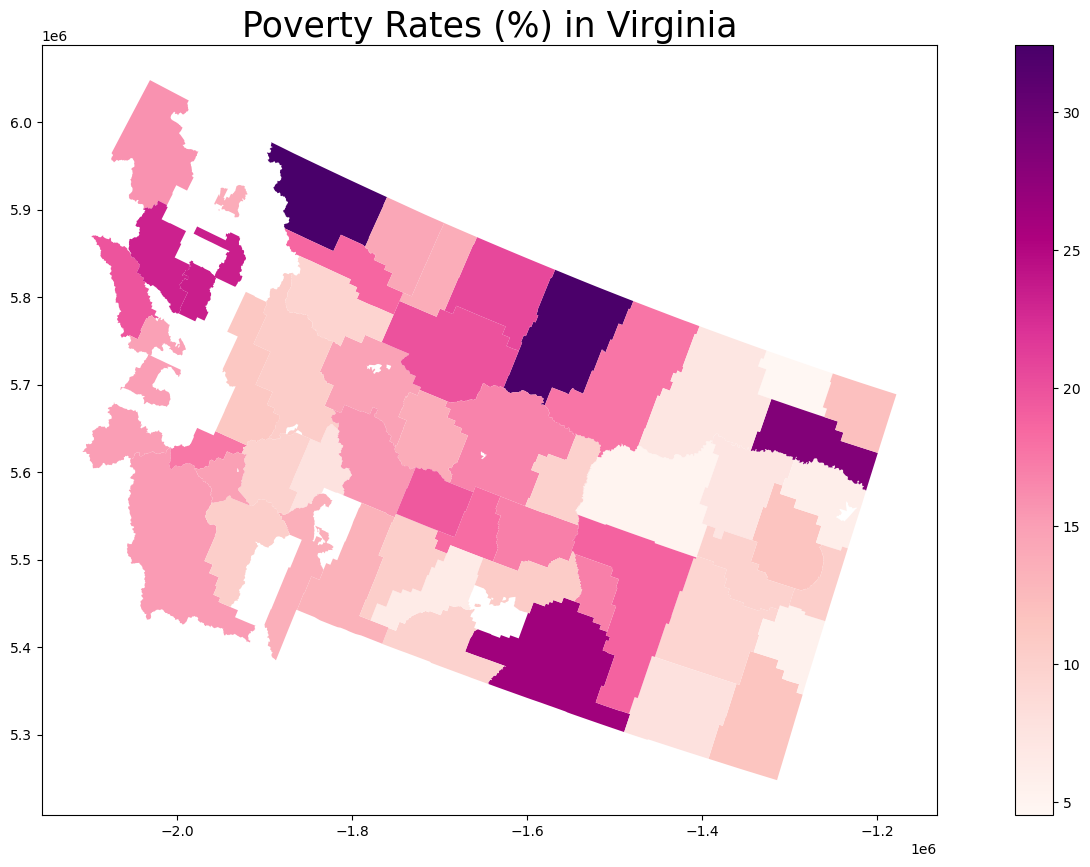

In [17]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
va_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Virginia', fontdict = {'fontsize': '25', 'fontweight' : '3'})